In [1]:
import sys; sys.path.append('..')
import torch
from torchsummary import summary
from src.models.autoencoder import AutoEncoder

DEVICE = 'cuda'

In [4]:
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.transforms import ToTensor

ds_train = CIFAR100('../data/CIFAR100', train=True, transform=ToTensor())
ds_test = CIFAR100('../data/CIFAR100', train=False, transform=ToTensor())

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# ds_train = Subset(ds_train, range(100))
# ds_test = Subset(ds_test, range(100))

NUM_CLASSES = 100

dl_train = DataLoader(ds_train, batch_size=256, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=256, shuffle=False)

In [6]:
import torch
import torch.nn as nn
from torch import Tensor
from firelab.config import Config

from src.models.layers import ConvBNReLU, ConvTransposeBNReLU, Reshape


class AutoEncoder(nn.Module):
    def __init__(self, config: Config):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

    def forward(self, x: Tensor) -> Tensor:
        return self.decoder(self.encoder(x))


class Encoder(nn.Module):
    def __init__(self, config: Config):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)
    

class Decoder(nn.Module):
    def __init__(self, config: Config):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)


class ShapePrinter(nn.Module):
    def __init__(self, title: str='unknown'):
        super(ShapePrinter, self).__init__()
        self.title = title

    def forward(self, x):
        print(self.title, x.shape, x.flatten(1).shape)
        return x

In [7]:
# ae = AutoEncoder(None).to('cuda')
# summary(ae, (3, 32, 32))

In [8]:
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np

ae = AutoEncoder(None).to(DEVICE)
optim = torch.optim.Adam(ae.parameters())
max_num_epochs = 1000


def validate_ae(model, dataloader):
    all_losses = []
    model.eval()
    
    with torch.no_grad():
        #for x, _ in tqdm(dataloader, desc='Validating', total=len(dataloader)):
        for x, _ in dataloader:
            x = x.to(DEVICE)
            #losses = F.binary_cross_entropy(model(x), x, reduction='none')
            losses = F.mse_loss(model(x), x, reduction='none')
            all_losses.extend(losses.cpu().tolist())
            
    return np.mean(all_losses)


for epoch in range(1, max_num_epochs + 1):
    for i, (x, _) in tqdm(enumerate(dl_train), desc='Training', total=len(dl_train)):
    #for i, (x, _) in enumerate(dl_train):
        ae.train()
        x = x.to(DEVICE)
        
        #loss = F.binary_cross_entropy(ae(x), x)
        loss = F.mse_loss(ae(x), x)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    if epoch % 10 == 0:
        print(f'[train] Epoch {epoch}. {validate_ae(ae, dl_train)}')
        print(f'[val] Epoch {epoch}: {validate_ae(ae, dl_test)}')

Training: 100%|██████████| 196/196 [00:08<00:00, 22.15it/s]


[train] Epoch 10. 0.004747151348391636


Training:   2%|▏         | 3/196 [00:00<00:09, 20.53it/s]

[val] Epoch 10: 0.004862835684405489


Training: 100%|██████████| 196/196 [00:08<00:00, 22.27it/s]


[train] Epoch 20. 0.0031599843178946045


Training:   2%|▏         | 3/196 [00:00<00:09, 21.14it/s]

[val] Epoch 20: 0.003260299431827597


Training: 100%|██████████| 196/196 [00:08<00:00, 23.24it/s]


[train] Epoch 30. 0.0025594644918384936


Training:   2%|▏         | 3/196 [00:00<00:09, 21.18it/s]

[val] Epoch 30: 0.002645398534398493


Training: 100%|██████████| 196/196 [00:08<00:00, 22.73it/s]


[train] Epoch 40. 0.0021329860041296215


Training:   2%|▏         | 3/196 [00:00<00:09, 20.78it/s]

[val] Epoch 40: 0.002214590129997666


Training: 100%|██████████| 196/196 [00:08<00:00, 22.38it/s]


[train] Epoch 50. 0.0020541734396856337


Training:   2%|▏         | 3/196 [00:00<00:09, 21.00it/s]

[val] Epoch 50: 0.0021353240802370957


Training: 100%|██████████| 196/196 [00:08<00:00, 23.25it/s]


[train] Epoch 60. 0.0016144194848847794


Training:   2%|▏         | 3/196 [00:00<00:09, 21.14it/s]

[val] Epoch 60: 0.0016866921246806727


Training: 100%|██████████| 196/196 [00:08<00:00, 23.09it/s]


[train] Epoch 70. 0.0014629789818644782


Training:   2%|▏         | 3/196 [00:00<00:09, 20.85it/s]

[val] Epoch 70: 0.0015346952230593238


Training: 100%|██████████| 196/196 [00:08<00:00, 23.25it/s]


[train] Epoch 80. 0.0012632557147045284


Training:   2%|▏         | 3/196 [00:00<00:09, 20.84it/s]

[val] Epoch 80: 0.001326683454804955


Training: 100%|██████████| 196/196 [00:08<00:00, 23.23it/s]


[train] Epoch 90. 0.0011532345244505877


Training:   2%|▏         | 3/196 [00:00<00:09, 21.20it/s]

[val] Epoch 90: 0.001209050560427102


Training: 100%|██████████| 196/196 [00:08<00:00, 23.00it/s]


[train] Epoch 100. 0.0010525005180668026


Training:   2%|▏         | 3/196 [00:00<00:09, 20.75it/s]

[val] Epoch 100: 0.0011084163050231774


Training: 100%|██████████| 196/196 [00:08<00:00, 23.18it/s]


[train] Epoch 110. 0.0010480445985795793


Training:   2%|▏         | 3/196 [00:00<00:09, 21.12it/s]

[val] Epoch 110: 0.001102669553727431


Training: 100%|██████████| 196/196 [00:08<00:00, 22.99it/s]


[train] Epoch 120. 0.0010995661429829653


Training:   2%|▏         | 3/196 [00:00<00:09, 21.17it/s]

[val] Epoch 120: 0.001152120547301128


Training: 100%|██████████| 196/196 [00:08<00:00, 23.30it/s]


[train] Epoch 130. 0.0009698188277311984


Training:   2%|▏         | 3/196 [00:00<00:09, 21.22it/s]

[val] Epoch 130: 0.0010227468880086431


Training: 100%|██████████| 196/196 [00:08<00:00, 23.31it/s]


[train] Epoch 140. 0.001045068591462229


Training:   1%|          | 2/196 [00:00<00:13, 14.05it/s]

[val] Epoch 140: 0.001097436152207693


Training: 100%|██████████| 196/196 [00:08<00:00, 22.22it/s]


[train] Epoch 150. 0.0008187431369470861


Training:   2%|▏         | 3/196 [00:00<00:09, 21.02it/s]

[val] Epoch 150: 0.0008684217118721513


Training: 100%|██████████| 196/196 [00:08<00:00, 23.30it/s]


[train] Epoch 160. 0.0007687432698710458


Training:   2%|▏         | 3/196 [00:00<00:09, 20.76it/s]

[val] Epoch 160: 0.0008161666711820806


Training: 100%|██████████| 196/196 [00:08<00:00, 23.27it/s]


[train] Epoch 170. 0.000766646714925544


Training:   1%|          | 2/196 [00:00<00:09, 19.82it/s]

[val] Epoch 170: 0.000813489059389245


Training: 100%|██████████| 196/196 [00:08<00:00, 22.97it/s]


[train] Epoch 180. 0.0008324512289045649


Training:   2%|▏         | 3/196 [00:00<00:09, 20.61it/s]

[val] Epoch 180: 0.0008814556659925255


Training: 100%|██████████| 196/196 [00:08<00:00, 23.27it/s]


[train] Epoch 190. 0.0009157703231318985


Training:   2%|▏         | 3/196 [00:00<00:09, 20.62it/s]

[val] Epoch 190: 0.0009614921019383296


Training: 100%|██████████| 196/196 [00:08<00:00, 23.20it/s]


[train] Epoch 200. 0.0007094174266641038


Training:   2%|▏         | 3/196 [00:00<00:09, 21.16it/s]

[val] Epoch 200: 0.0007504221330032504


Training: 100%|██████████| 196/196 [00:08<00:00, 23.04it/s]


[train] Epoch 210. 0.0006771427767837151


Training:   2%|▏         | 3/196 [00:00<00:09, 20.73it/s]

[val] Epoch 210: 0.0007206859339235637


Training: 100%|██████████| 196/196 [00:08<00:00, 22.08it/s]


[train] Epoch 220. 0.0007742465748536812


Training:   2%|▏         | 3/196 [00:00<00:09, 20.68it/s]

[val] Epoch 220: 0.0008188612477726816


Training: 100%|██████████| 196/196 [00:08<00:00, 23.20it/s]


[train] Epoch 230. 0.0005719470188702878


Training:   1%|          | 2/196 [00:00<00:09, 19.85it/s]

[val] Epoch 230: 0.0006101012952340194


Training: 100%|██████████| 196/196 [00:08<00:00, 22.99it/s]


[train] Epoch 240. 0.0005926391763511397


Training:   2%|▏         | 3/196 [00:00<00:09, 20.76it/s]

[val] Epoch 240: 0.0006322736284784211


Training: 100%|██████████| 196/196 [00:08<00:00, 23.28it/s]


[train] Epoch 250. 0.0005635629746000943


Training:   2%|▏         | 3/196 [00:00<00:09, 20.37it/s]

[val] Epoch 250: 0.0006050127454245959


Training: 100%|██████████| 196/196 [00:08<00:00, 22.39it/s]


[train] Epoch 260. 0.0005629930954899012


Training:   2%|▏         | 3/196 [00:00<00:09, 21.13it/s]

[val] Epoch 260: 0.0006012874225038662


Training: 100%|██████████| 196/196 [00:08<00:00, 22.67it/s]


[train] Epoch 270. 0.0005359089058808057


Training:   2%|▏         | 3/196 [00:00<00:09, 21.07it/s]

[val] Epoch 270: 0.00057410399859949


Training: 100%|██████████| 196/196 [00:08<00:00, 23.29it/s]


[train] Epoch 280. 0.0005650781541088895


Training:   2%|▏         | 3/196 [00:00<00:09, 21.19it/s]

[val] Epoch 280: 0.0006014158102841913


Training: 100%|██████████| 196/196 [00:08<00:00, 22.93it/s]


[train] Epoch 290. 0.0005553239366407263


Training:   2%|▏         | 3/196 [00:00<00:09, 21.22it/s]

[val] Epoch 290: 0.000593196476466939


Training: 100%|██████████| 196/196 [00:08<00:00, 23.33it/s]


[train] Epoch 300. 0.0005958692412555974


Training:   2%|▏         | 3/196 [00:00<00:09, 21.23it/s]

[val] Epoch 300: 0.0006371248968336333


Training: 100%|██████████| 196/196 [00:08<00:00, 23.31it/s]


[train] Epoch 310. 0.0006442276226624866


Training:   2%|▏         | 3/196 [00:00<00:09, 20.72it/s]

[val] Epoch 310: 0.000683624567291889


Training: 100%|██████████| 196/196 [00:08<00:00, 22.42it/s]


[train] Epoch 320. 0.0006862594211780981


Training:   2%|▏         | 3/196 [00:00<00:09, 21.06it/s]

[val] Epoch 320: 0.0007252908857956258


Training: 100%|██████████| 196/196 [00:08<00:00, 23.26it/s]


[train] Epoch 330. 0.0004962174179854411


Training:   2%|▏         | 3/196 [00:00<00:09, 20.73it/s]

[val] Epoch 330: 0.000533787203793608


Training: 100%|██████████| 196/196 [00:08<00:00, 23.36it/s]


[train] Epoch 340. 0.0004805938332428556


Training:   1%|          | 2/196 [00:00<00:13, 13.94it/s]

[val] Epoch 340: 0.0005190475616326361


Training: 100%|██████████| 196/196 [00:08<00:00, 23.27it/s]


[train] Epoch 350. 0.0004992103495216394


Training:   2%|▏         | 3/196 [00:00<00:09, 21.04it/s]

[val] Epoch 350: 0.0005331193605189719


Training: 100%|██████████| 196/196 [00:08<00:00, 23.18it/s]


[train] Epoch 360. 0.0005199086040133616


Training:   1%|          | 2/196 [00:00<00:14, 13.54it/s]

[val] Epoch 360: 0.0005541050712298389


Training: 100%|██████████| 196/196 [00:08<00:00, 22.93it/s]


[train] Epoch 370. 0.0005092462285189643


Training:   1%|          | 2/196 [00:00<00:09, 19.76it/s]

[val] Epoch 370: 0.0005431401542619757


Training: 100%|██████████| 196/196 [00:08<00:00, 22.26it/s]


[train] Epoch 380. 0.0004908923599541018


Training:   1%|          | 2/196 [00:00<00:14, 13.78it/s]

[val] Epoch 380: 0.0005261350577143598


Training: 100%|██████████| 196/196 [00:08<00:00, 22.97it/s]


[train] Epoch 390. 0.0005893791644285697


Training:   1%|          | 2/196 [00:00<00:13, 14.22it/s]

[val] Epoch 390: 0.0006278553819760163


Training: 100%|██████████| 196/196 [00:08<00:00, 23.46it/s]


[train] Epoch 400. 0.0004368490272594689


Training:   1%|          | 2/196 [00:00<00:13, 14.13it/s]

[val] Epoch 400: 0.00047124709716599275


Training: 100%|██████████| 196/196 [00:08<00:00, 23.36it/s]


[train] Epoch 410. 0.0005004874827174066


Training:   1%|          | 2/196 [00:00<00:10, 19.30it/s]

[val] Epoch 410: 0.0005341053094629494


Training: 100%|██████████| 196/196 [00:08<00:00, 23.32it/s]


[train] Epoch 420. 0.0005117053722570675


Training:   1%|          | 2/196 [00:00<00:09, 19.66it/s]

[val] Epoch 420: 0.0005474269344314249


Training: 100%|██████████| 196/196 [00:08<00:00, 22.35it/s]


[train] Epoch 430. 0.0004566981308268551


Training:   2%|▏         | 3/196 [00:00<00:09, 21.25it/s]

[val] Epoch 430: 0.0004883090977672311


Training: 100%|██████████| 196/196 [00:08<00:00, 23.38it/s]


[train] Epoch 440. 0.000464469710174093


Training:   2%|▏         | 3/196 [00:00<00:09, 21.13it/s]

[val] Epoch 440: 0.0004994516369308346


Training: 100%|██████████| 196/196 [00:08<00:00, 23.15it/s]


[train] Epoch 450. 0.0003935653002038268


Training:   2%|▏         | 3/196 [00:00<00:09, 20.65it/s]

[val] Epoch 450: 0.0004251242651695832


Training: 100%|██████████| 196/196 [00:08<00:00, 23.94it/s]


[train] Epoch 460. 0.0004964127204547004


Training:   2%|▏         | 3/196 [00:00<00:09, 20.61it/s]

[val] Epoch 460: 0.0005301627518574931


Training: 100%|██████████| 196/196 [00:08<00:00, 22.35it/s]


[train] Epoch 470. 0.0004102399578818924


Training:   2%|▏         | 3/196 [00:00<00:09, 20.83it/s]

[val] Epoch 470: 0.00044264953628900613


Training: 100%|██████████| 196/196 [00:08<00:00, 22.94it/s]


[train] Epoch 480. 0.0004736697246026588


Training:   2%|▏         | 3/196 [00:00<00:09, 21.11it/s]

[val] Epoch 480: 0.0005079775228259458


Training: 100%|██████████| 196/196 [00:08<00:00, 23.24it/s]


[train] Epoch 490. 0.000469523492691153


Training:   1%|          | 2/196 [00:00<00:13, 14.54it/s]

[val] Epoch 490: 0.0005020904359772766


Training: 100%|██████████| 196/196 [00:08<00:00, 23.24it/s]


[train] Epoch 500. 0.00040236324226563717


Training:   2%|▏         | 3/196 [00:00<00:09, 20.90it/s]

[val] Epoch 500: 0.0004339493649277298


Training: 100%|██████████| 196/196 [00:08<00:00, 22.65it/s]


[train] Epoch 510. 0.00039030783525903647


Training:   2%|▏         | 3/196 [00:00<00:09, 20.87it/s]

[val] Epoch 510: 0.0004204712033995495


Training: 100%|██████████| 196/196 [00:08<00:00, 23.31it/s]


[train] Epoch 520. 0.00039374968003127184


Training:   1%|          | 2/196 [00:00<00:13, 14.31it/s]

[val] Epoch 520: 0.00042525678244239516


Training: 100%|██████████| 196/196 [00:08<00:00, 22.69it/s]


[train] Epoch 530. 0.0003727260662037754


Training:   1%|          | 2/196 [00:00<00:13, 14.04it/s]

[val] Epoch 530: 0.0004021117283227188


Training: 100%|██████████| 196/196 [00:08<00:00, 23.25it/s]


[train] Epoch 540. 0.00034554766348506255


Training:   2%|▏         | 3/196 [00:00<00:09, 21.36it/s]

[val] Epoch 540: 0.00037604014702268516


Training: 100%|██████████| 196/196 [00:08<00:00, 23.11it/s]


[train] Epoch 550. 0.0003929110620090521


Training:   2%|▏         | 3/196 [00:00<00:09, 20.85it/s]

[val] Epoch 550: 0.0004224494766479541


Training: 100%|██████████| 196/196 [00:08<00:00, 22.54it/s]


[train] Epoch 560. 0.00046446454040677027


Training:   2%|▏         | 3/196 [00:00<00:09, 21.25it/s]

[val] Epoch 560: 0.0004948501674110423


Training: 100%|██████████| 196/196 [00:08<00:00, 23.10it/s]


[train] Epoch 590. 0.00041816554856722823


Training:   1%|          | 2/196 [00:00<00:14, 13.38it/s]

[val] Epoch 590: 0.0004486927913776204


Training: 100%|██████████| 196/196 [00:08<00:00, 23.16it/s]


[train] Epoch 600. 0.0003992183777737702


Training:   2%|▏         | 3/196 [00:00<00:09, 21.23it/s]

[val] Epoch 600: 0.00042985946601310635


Training:  19%|█▉        | 38/196 [00:01<00:07, 20.31it/s]

[train] Epoch 620. 0.00043193428610635814


Training:   1%|          | 2/196 [00:00<00:13, 14.18it/s]

[val] Epoch 620: 0.0004633047361570878


Training: 100%|██████████| 196/196 [00:08<00:00, 23.32it/s]


[train] Epoch 630. 0.0003181619106687803


Training:   1%|          | 2/196 [00:00<00:14, 13.37it/s]

[val] Epoch 630: 0.00034652972880005464


Training: 100%|██████████| 196/196 [00:08<00:00, 23.16it/s]


[train] Epoch 640. 0.00041011308880438765


Training:   2%|▏         | 3/196 [00:00<00:09, 21.21it/s]

[val] Epoch 640: 0.0004391459166098867


Training: 100%|██████████| 196/196 [00:08<00:00, 22.70it/s]


[train] Epoch 650. 0.0003639422303054998


Training:   2%|▏         | 3/196 [00:00<00:09, 21.29it/s]

[val] Epoch 650: 0.0003920797689655438


Training: 100%|██████████| 196/196 [00:08<00:00, 21.79it/s]


[train] Epoch 670. 0.000327585171680723


Training:   2%|▏         | 3/196 [00:00<00:09, 20.54it/s]

[val] Epoch 670: 0.00035874693410538566


Training: 100%|██████████| 196/196 [00:08<00:00, 23.06it/s]


[train] Epoch 680. 0.00035754353225914907


Training:   2%|▏         | 3/196 [00:00<00:09, 20.76it/s]

[val] Epoch 680: 0.00038711503599594667


Training: 100%|██████████| 196/196 [00:08<00:00, 22.74it/s]


[train] Epoch 700. 0.00032128452096696756


Training:   2%|▏         | 3/196 [00:00<00:09, 21.21it/s]

[val] Epoch 700: 0.0003517459848105935


Training: 100%|██████████| 196/196 [00:08<00:00, 23.10it/s]


[train] Epoch 710. 0.00032978744757576536


Training:   1%|          | 2/196 [00:00<00:09, 19.62it/s]

[val] Epoch 710: 0.00035744617943298716


Training: 100%|██████████| 196/196 [00:08<00:00, 23.31it/s]


[train] Epoch 720. 0.00032783699412896824


Training:   2%|▏         | 3/196 [00:00<00:09, 20.99it/s]

[val] Epoch 720: 0.0003550754017453988


Training: 100%|██████████| 196/196 [00:08<00:00, 23.11it/s]


[train] Epoch 730. 0.00030660719364992154


Training:   2%|▏         | 3/196 [00:00<00:09, 20.83it/s]

[val] Epoch 730: 0.0003350219713067801


Training:  73%|███████▎  | 144/196 [00:06<00:02, 23.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training: 100%|██████████| 196/196 [00:08<00:00, 23.57it/s]


[train] Epoch 760. 0.0003580794653644826


Training:   2%|▏         | 3/196 [00:00<00:09, 21.08it/s]

[val] Epoch 760: 0.00038535101672439555


Training: 100%|██████████| 196/196 [00:08<00:00, 23.36it/s]


[train] Epoch 770. 0.0003352501253293334


Training:   2%|▏         | 3/196 [00:00<00:09, 20.93it/s]

[val] Epoch 770: 0.00036519219783872573


Training: 100%|██████████| 196/196 [00:08<00:00, 23.34it/s]


[train] Epoch 780. 0.00034214730344359035


Training:   2%|▏         | 3/196 [00:00<00:09, 20.85it/s]

[val] Epoch 780: 0.0003686650072287782


Training: 100%|██████████| 196/196 [00:08<00:00, 23.38it/s]


[train] Epoch 790. 0.00035750756326891395


Training:   2%|▏         | 3/196 [00:00<00:09, 21.26it/s]

[val] Epoch 790: 0.00038565586989378493


Training: 100%|██████████| 196/196 [00:08<00:00, 23.39it/s]


[train] Epoch 800. 0.0003261137819681138


Training:   2%|▏         | 3/196 [00:00<00:09, 21.25it/s]

[val] Epoch 800: 0.0003524299346516195


Training: 100%|██████████| 196/196 [00:08<00:00, 22.83it/s]


[train] Epoch 810. 0.00031568370428278035


Training:   1%|          | 2/196 [00:00<00:13, 14.25it/s]

[val] Epoch 810: 0.000341297159678017


Training: 100%|██████████| 196/196 [00:08<00:00, 23.45it/s]


[train] Epoch 820. 0.00030957757207201406


Training:   2%|▏         | 3/196 [00:00<00:09, 20.88it/s]

[val] Epoch 820: 0.0003348258764247522


Training: 100%|██████████| 196/196 [00:08<00:00, 23.38it/s]


[train] Epoch 830. 0.00037674001279376185


Training:   2%|▏         | 3/196 [00:00<00:09, 21.24it/s]

[val] Epoch 830: 0.0004032397753972954


Training:  15%|█▍        | 29/196 [00:01<00:07, 22.32it/s]

[train] Epoch 840. 0.0002912099367467597


Training:   2%|▏         | 3/196 [00:00<00:09, 21.10it/s]

[val] Epoch 840: 0.0003184087997559286


Training: 100%|██████████| 196/196 [00:08<00:00, 22.64it/s]


[train] Epoch 870. 0.0005659824305443879


Training:   2%|▏         | 3/196 [00:00<00:09, 21.26it/s]

[val] Epoch 870: 0.000595194650336105


Training:  68%|██████▊   | 134/196 [00:05<00:02, 23.76it/s]

[train] Epoch 880. 0.00033153540908714924


Training:   2%|▏         | 3/196 [00:00<00:09, 21.23it/s]

[val] Epoch 880: 0.00035675089672900634


Training: 100%|██████████| 196/196 [00:08<00:00, 22.90it/s]


[train] Epoch 960. 0.0003311427055207473


Training:   2%|▏         | 3/196 [00:00<00:09, 21.11it/s]

[val] Epoch 960: 0.00035726094429151


Training: 100%|██████████| 196/196 [00:08<00:00, 22.70it/s]


[train] Epoch 970. 0.0003153808274209864


Training:   2%|▏         | 3/196 [00:00<00:09, 21.07it/s]

[val] Epoch 970: 0.0003412994620850067


Training: 100%|██████████| 196/196 [00:08<00:00, 23.25it/s]


[train] Epoch 980. 0.0002920967905281834


Training:   2%|▏         | 3/196 [00:00<00:09, 21.15it/s]

[val] Epoch 980: 0.00031858880437262826


Training: 100%|██████████| 196/196 [00:08<00:00, 23.97it/s]


[train] Epoch 990. 0.0002711092609101993


Training:   1%|          | 2/196 [00:00<00:09, 19.98it/s]

[val] Epoch 990: 0.000294963248400291


Training: 100%|██████████| 196/196 [00:08<00:00, 23.09it/s]


[train] Epoch 1000. 0.00026746818470926804
[val] Epoch 1000: 0.00029066762205507


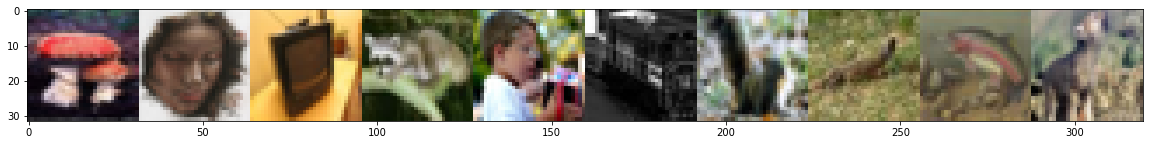

In [9]:
import random
import matplotlib.pyplot as plt

ae.eval()

with torch.no_grad():
    imgs = [ds_test[i][0] for i in random.sample(range(len(ds_test)), 10)]
    recs = [ae(img.unsqueeze(0).to(DEVICE)).cpu().squeeze(0) for img in imgs]

    imgs = [img.permute(1, 2, 0).numpy() for img in imgs]
    recs = [rec.permute(1, 2, 0).numpy() for rec in recs]

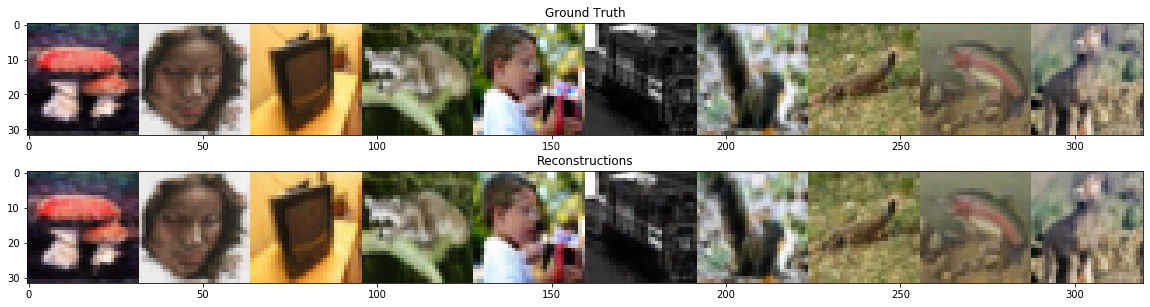

In [18]:
plt.figure(figsize=(20, 5))
plt.subplot(211)
plt.title('[val] Ground Truth')
plt.imshow(np.stack(imgs, axis=1).reshape(32, -1, 3), interpolation='nearest')

plt.subplot(212)
plt.title('[val] Reconstructions')
plt.imshow(np.stack(recs, axis=1).reshape(32, -1, 3), interpolation='nearest')

In [11]:
def extract_features(ae, dataloader):
    ae.eval()
    
    y = []
    feats = []
    
    with torch.no_grad():
        for batch in dataloader:
            feats.extend(ae.encoder(batch[0].to(DEVICE)).cpu().flatten(1).tolist())
            y.extend(batch[1])
            
    return feats, y

feats_train, y_train = extract_features(ae, dl_train)
feats_test, y_test = extract_features(ae, dl_test)

In [12]:
feats_dl_train = DataLoader(list(zip(*[feats_train, y_train])), batch_size=256, shuffle=True, collate_fn=lambda b: list(zip(*b)))
feats_dl_test = DataLoader(list(zip(*[feats_test, y_test])), batch_size=256, shuffle=False, collate_fn=lambda b: list(zip(*b)))

In [13]:
ds = list(zip(*[feats_train, y_train]))

In [ ]:
def validate_clf(clf_model, dataloader):
    losses = []
    accs = []

    with torch.no_grad():
        for x, y in dataloader:
            x = torch.tensor(x).to(DEVICE)
            y = torch.tensor(y).to(DEVICE)

            logits = clf_model(x)
            loss = F.cross_entropy(logits, y, reduction='none').cpu().tolist()
            acc = (logits.argmax(dim=1) == y).float().cpu().tolist()
            
            losses.extend(loss)
            accs.extend(acc)
        
    return np.mean(losses), np.mean(accs)

In [28]:
classifier = nn.Sequential(
    #nn.Dropout(0.1),
    #nn.Linear(2048, 256),
    #nn.BatchNorm1d(256),
    #nn.ReLU(),
    #nn.Dropout(0.1),
    #nn.Linear(256, 100)
    nn.Linear(2048, 100)
).to(DEVICE)

max_num_epochs = 100
optim = torch.optim.Adam(classifier.parameters(), lr=1e-2)

for epoch in range(max_num_epochs):
    for batch in feats_dl_train:
        x = torch.tensor(batch[0]).to(DEVICE)
        y = torch.tensor(batch[1]).to(DEVICE)

        logits = classifier(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean().detach().cpu()

        optim.zero_grad()
        loss.backward()
        optim.step()

    #print('acc', acc.item())
    if epoch % 5 == 0:
        print('train acc:', validate_clf(classifier, feats_dl_train)[1])
        print('val acc:', validate_clf(classifier, feats_dl_test)[1])

train acc: 0.21184
val acc: 0.184
train acc: 0.34842
val acc: 0.2274
train acc: 0.38474
val acc: 0.2253
train acc: 0.41748
val acc: 0.2221
train acc: 0.44646
val acc: 0.2243
train acc: 0.4422
val acc: 0.2191
train acc: 0.49832
val acc: 0.2282
train acc: 0.50374
val acc: 0.229
train acc: 0.48506
val acc: 0.2152


KeyboardInterrupt: 